In [30]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def compute_ece(predictions, labels, n_bins=10, strategy='uniform'):
    """
    Compute the Expected Calibration Error (ECE).
    
    :param predictions: A numpy array of predicted probabilities.
    :param labels: A numpy array of true labels (0 or 1).
    :param n_bins: The number of bins to use (default is 10).
    :param strategy: The strategy used to define the widths of the bins ('uniform' or 'quantile').
    :return: The ECE value.
    """
    if strategy not in ['uniform', 'quantile']:
        raise ValueError("Invalid strategy: choose either 'uniform' or 'quantile'")
    
    if strategy == 'uniform':
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
    elif strategy == 'quantile':
        bin_boundaries = np.percentile(predictions, np.linspace(0, 100, n_bins + 1))
    
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0.0
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find the indices where the predicted probabilities fall into the current bin
        in_bin = np.logical_and(predictions > bin_lower, predictions <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        
        if prop_in_bin > 0:
            # Compute the accuracy and confidence in the current bin
            accuracy_in_bin = np.mean(labels[in_bin])
            avg_confidence_in_bin = np.mean(predictions[in_bin])
            # Update the ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

In [19]:
def logloss_with_logits(beta, X, y, reg_alpha=0.0):
    z = X @ beta
    return (z*(1 - y) + np.log1p(np.exp(-z))).mean() + np.abs(beta).mean()*reg_alpha

def logloss(beta, X, y, reg_alpha=0.0):
    p_hat = sigmoid(X @ beta)
    return -(y * np.log(p_hat) + (1 - y) * np.log(1 - p_hat)).mean() + np.abs(beta).mean()*reg_alpha

In [20]:
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score

def generate_data(
        train_max_size: int=8000, 
        test_size: int=10000, 
        dim: int=800, 
        mu_x: float=0.0,
        sigma2_x: float=0.00025, 
        mu_beta: float=3.0, 
        sigma2_beta: float=16.0, 
        seed: int=42
    ):

    np.random.seed(seed)

    n = train_max_size + test_size

    X = mu_x + np.random.randn(n, dim) * np.sqrt(sigma2_x)
    beta = mu_beta + np.random.randn(dim) * np.sqrt(sigma2_beta)

    logits = X.dot(beta)
    probs = sigmoid(logits)
    y = np.random.binomial(1, probs)

    X_train, y_train = X[:train_max_size], y[:train_max_size]

    X_test, y_test = X[-test_size:], y[-test_size:] 

    return X_train, y_train, X_test, y_test, beta

def estimate_beta(X, y, reg_alpha=0.0):
    res = minimize(
        logloss_with_logits, 
        np.random.randn(X.shape[1]), 
        (X, y, reg_alpha), 
        method='L-BFGS-B'
    )

    beta_hat = res.x

    return beta_hat

def calculate_metrics(y_true, probs_true, beta_true, probs_pred, beta_pred):
    mae_prob = mean_absolute_error(probs_true, probs_pred)
    mae_beta = mean_absolute_error(beta_true, beta_pred)
    ece = compute_ece(probs_pred, y_true)
    accuracy = accuracy_score(y_true, probs_pred>=.5)
    roc_auc  = roc_auc_score(y_true, probs_true)
    return {
                'mae_prob': mae_prob, 
                'mae_beta': mae_beta, 
                'ece': ece, 
                'accuracy': accuracy, 
                'roc_auc': roc_auc,
           }

In [ ]:

import numpy as np 

results = []

for seed in range(1):

    X_train, y_train, X_test, y_test, beta_true = generate_data(seed=seed)
    probs_test = sigmoid(X_test@beta_true)

    sample_sizes = [125, 250, 500, 1000, 2000, 4000]

    for sample_size in sample_sizes:
        X_train_sample, y_train_sample = X_train[:sample_size], y_train[:sample_size]

        beta_pred = estimate_beta(X_train_sample, y_train_sample, reg_alpha=0.01)
        probs_pred = sigmoid(X_test @ beta_pred)

        metrics_dict = calculate_metrics(y_test, probs_test, beta_true, probs_pred, beta_pred)
        metrics_dict.update({'seed': seed, 'method': 'noised_probs', 'sample_size': sample_size})

        results.append(metrics_dict)

        for noise in [0.0, 0.5, 1.0, 1.5]:
            prob_corrupted = sigmoid(X_train_sample@beta_true + noise*np.random.randn(sample_size)) 
            
            beta_pred = estimate_beta(X_train_sample, prob_corrupted)
            probs_pred = sigmoid(X_test @ beta_pred)

            metrics_dict = calculate_metrics(y_test, probs_test, beta_true, probs_pred, beta_pred)
            metrics_dict.update({'seed': seed, 'method': f'noised_probs_{noise}', 'sample_size': sample_size})

            results.append(metrics_dict)


In [27]:
results_df = pd.DataFrame(results).groupby(['method', 'sample_size'])[['mae_prob', 'ece', 'mae_beta']].mean().reset_index()

In [28]:
results_df

,method,sample_size,mae_prob,ece,mae_beta
0,noised_probs,125,0.334851,0.247686,4.917732
1,noised_probs,250,0.330815,0.259548,5.378036
2,noised_probs,500,0.325661,0.284198,6.270522
3,noised_probs,1000,0.294604,0.263336,7.900650
4,noised_probs,2000,0.257520,0.232698,8.364043
5,noised_probs,4000,0.146368,0.100833,2.619773
6,noised_probs_0.0,125,0.266979,0.075290,3.732384
7,noised_probs_0.0,250,0.238090,0.069323,3.408583
8,noised_probs_0.0,500,0.175175,0.052596,2.593020
9,noised_probs_0.0,1000,0.067114,0.012263,1.043067


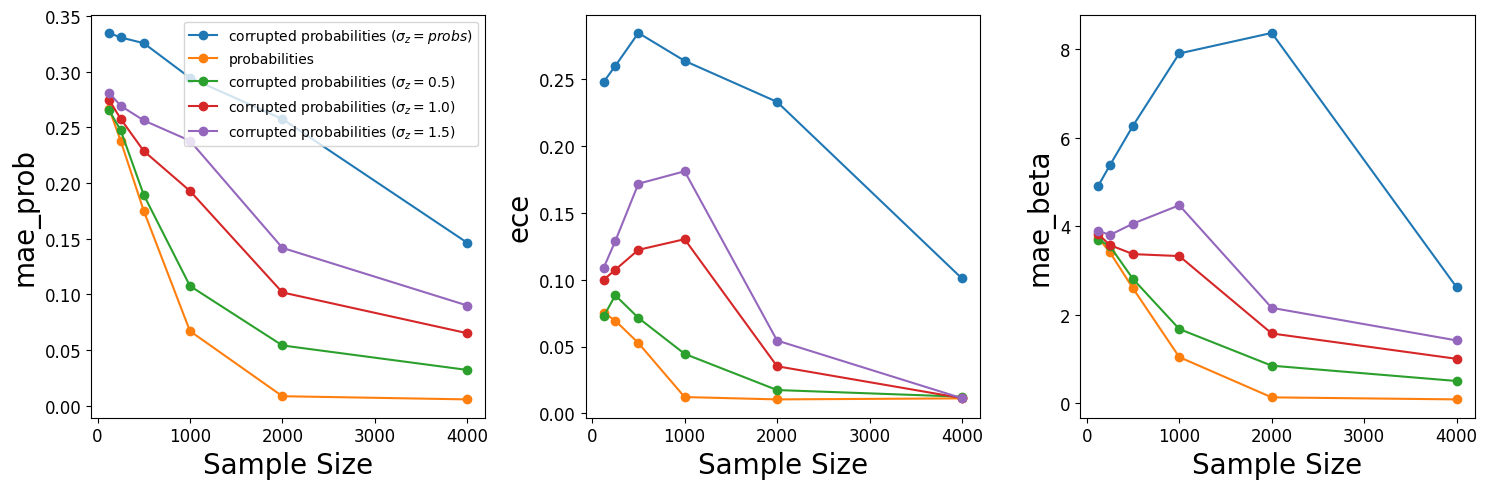

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for method in results_df['method'].unique():
    if method == 'labels':
        label = 'labels'
    if 'noised_probs' in method:
        if method == 'noised_probs_0.0':
            label = 'probabilities'
        else:
            label = rf"corrupted probabilities ($\sigma_z = {method.split('_')[-1]}$)"

    for metric, ax in zip(['mae_prob', 'ece', 'mae_beta'], axes):
        ax.plot(results_df[results_df['method'] == method]['sample_size'], 
                results_df[results_df['method'] == method][metric], 
                label=label,
                marker='o')
        
        ax.set_xlabel('Sample Size', fontsize=20)
        ax.set_ylabel(metric, fontsize=20)

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)

axes[0].legend()

plt.tight_layout()

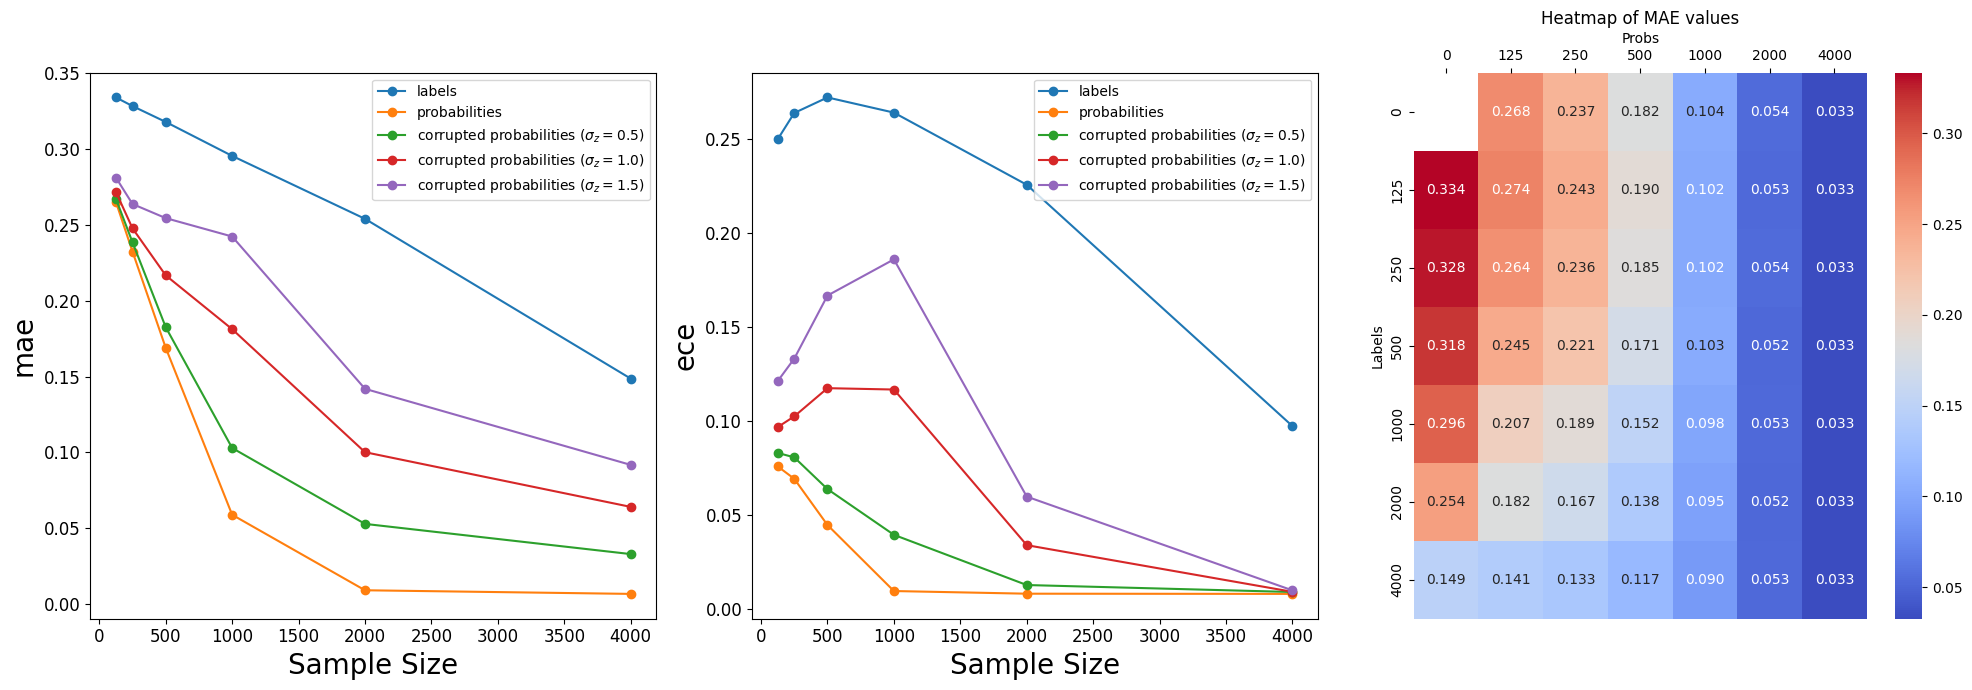

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for method in results_df['method'].unique():
    if method == 'labels':
        label = 'labels'
    if 'noised_probs' in method:
        if method == 'noised_probs_0.0':
            label = 'probabilities'
        else:
            label = rf"corrupted probabilities ($\sigma_z = {method.split('_')[-1]}$)"

    for metric, ax in zip(['mae', 'ece'], axes):
        ax.plot(results_df[results_df['method'] == method]['sample_size'], 
                results_df[results_df['method'] == method][metric], 
                label=label,
                marker='o')
        
        ax.set_xlabel('Sample Size', fontsize=20)
        ax.set_ylabel(metric, fontsize=20)
        

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)

        ax.legend()

sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".3f", ax=axes[2])

# Move x-axis labels to the top
axes[2].xaxis.tick_top()
axes[2].xaxis.set_label_position('top')

# Adding titles and labels
axes[2].set_title('Heatmap of MAE values')
axes[2].set_xlabel('Probs')
axes[2].set_ylabel('Labels')

plt.tight_layout()
# plt.savefig('mae_ece.pdf', dpi=300)

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

sample_sizes = [0, 125, 250, 500, 1000, 2000, 4000] # [0, 20, 50, 150, 400, 1000, 2000, 3000]

results = []

for seed in range(10):
    np.random.seed(seed)
    X = np.random.randn(n, p) / np.sqrt(4000)
    beta = 3 + 4*np.random.randn(p)

    logits = X.dot(beta)
    probs = sigmoid(logits)
    y = np.random.binomial(1, probs)

    X_test = X[-10000:]
    y_test = y[-10000:]

    for label_size in sample_sizes:
        for prob_size in sample_sizes:
            train_total = label_size + prob_size
            beta_hat = np.random.randn(p)
            if train_total > 0:
                X_train = X[:train_total]
                y_train = y[:train_total]

                if label_size > 0:
                    reg_lambda = 0.1 if (prob_size > 0) and (label_size <= 2000) else 0.01
                    res = minimize(logloss_with_logits, beta_hat, (X_train[:label_size], y_train[:label_size], reg_lambda), method='L-BFGS-B')#, options={'maxiter': 10000, 'maxfun': 10000000})#, tol=1e-9)
                    beta_hat = res.x

                if prob_size > 0:
                    y_train_prob = sigmoid(X_train[label_size:] @ beta + .5*np.random.randn(prob_size))

                    res = minimize(logloss_opt, beta_hat, (X_train[label_size:], y_train_prob, 0.0), method='L-BFGS-B')#, options={'maxiter': 10000, 'maxfun': 10000000})
                    beta_hat = res.x

                probs_hat = sigmoid(X_test @ beta_hat)

                results.append({
                    'labels': label_size,
                    'probs':  prob_size,
                    'ECE': compute_ece(probs_hat, y_test),
                    'MAE': mean_absolute_error(sigmoid(X_test @ beta), probs_hat),
                    'seed': seed
                })

            else:
                results.append({
                    'labels': label_size,
                    'probs':  prob_size,
                    'ECE': np.nan,
                    'MAE': np.nan,
                })

In [81]:
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.43809570185980673
        x: [ 3.320e+00  9.304e-01 ...  4.158e+00  8.405e+00]
      nit: 7
      jac: [ 4.774e-07 -5.551e-09 ...  1.155e-06 -1.166e-07]
     nfev: 8010
     njev: 10
 hess_inv: <800x800 LbfgsInvHessProduct with dtype=float64>

In [82]:
# a = pd.read_csv('cool_results.csv') #pd.DataFrame(results).to_csv('cool_results.csv', index=False)
# pd.DataFrame(results).to_csv('reg_005_001.csv', index=False)

In [91]:
df = pd.pivot_table(pd.DataFrame(results), index='labels', columns='probs', values='MAE', aggfunc='mean')
df

probs,0,125,250,500,1000,2000,4000
labels,,,,,,,
0,NaN,0.267850,0.236513,0.182226,0.103908,0.053989,0.033419
125,0.333559,0.274188,0.243093,0.190046,0.102260,0.052831,0.032517
250,0.328221,0.264387,0.236109,0.184764,0.102117,0.053778,0.033220
500,0.317961,0.244940,0.220855,0.171416,0.103091,0.051916,0.033270
1000,0.295500,0.206631,0.188697,0.151716,0.098479,0.053280,0.032755
2000,0.253897,0.182354,0.167411,0.138269,0.094964,0.052455,0.033034
4000,0.148637,0.140655,0.133304,0.117486,0.089935,0.052851,0.033347


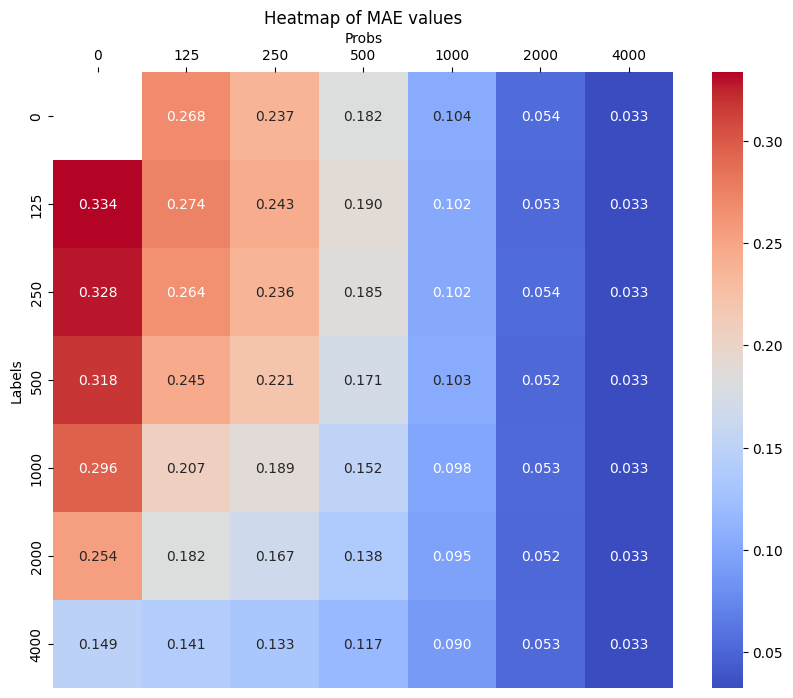

In [ ]:
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".3f")

# Move x-axis labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Adding titles and labels
plt.title('Heatmap of MAE values')
plt.xlabel('Probs')
plt.ylabel('Labels')

# Show the plot
plt.show()

In [93]:
pd.DataFrame(results).to_csv('heatmap_data.csv', index=False)

In [73]:
X = np.random.randn(n, p) / np.sqrt(4000)
beta = 3 + 4*np.random.randn(p)

logits = X.dot(beta)
probs = sigmoid(logits)
y = np.random.binomial(1, probs)

In [107]:
n_samples = 500

X_train, y_train = X[:n_samples], y[:n_samples]
X_test, y_test = X[-10000:], y[-10000:]

In [123]:
def logloss(beta, X, y, eps=1e-9):
    p_hat = sigmoid(X @ beta)
    return -(y * np.log(p_hat + eps) + (1 - y) * np.log(1 - p_hat + eps)).mean()

def logloss_opt(beta, X, y):
    z = X @ beta
    return (z*(1 - y) + np.log1p(np.exp(-z))).mean() 

def logloss_comb(beta, X, y, p, alpha=1.0):
    p_hat = sigmoid(X @ beta)
    loss_hard = -(y * np.log(p_hat + eps) + (1 - y) * np.log(1 - p_hat + eps)).mean()
    loss_soft = -(p * np.log(p_hat + eps) + (1 - p) * np.log(1 - p_hat + eps)).mean()
    return loss_hard*alpha + loss_soft*(1-alpha)

In [1]:
import numpy as np

In [4]:
from dataclasses import dataclass, field


@dataclass
class EstimateBetaConfig:
    reg_alpha: float = 0.1
    init_beta: np.ndarray = field(default_factory=lambda: None)

In [1]:
pip install hydra

  Using cached Hydra-2.5.tar.gz (82 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for hydra
Failed to build hydra
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [9 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      copying src\hydra.py -> build\lib.win-amd64-cpython-311
      running build_ext
      building '_hydra' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for hydra
ERROR: Could not build wheels for hydra, which is required to install pyproject.toml-based projects


In [9]:
EstimateBetaConfig().reg_alpha

0.1